In [1]:
!pip install matplotlib scikit-learn

In [15]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import pathlib
import random
import string
import re
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import datetime
print(f"Tensorflow Version: {tf.__version__}")

Tensorflow Version: 2.15.0


In [3]:
class Config:
    vocab_size = 16000 # Vocabulary Size
    sequence_length = 20
    batch_size = 512
    validation_split = 0.15
    embed_dim = 256
    latent_dim = 256
    num_heads = 4
    epochs = 30 # Number of Epochs to train
    is_training = False

config = Config()

In [4]:
!gdown https://drive.google.com/file/d/1muYCUnsqg8eb8W2nsy94ezCfBPd_hcPx/view?usp=sharing --fuzzy -O data.csv

Downloading...
From: https://drive.google.com/uc?id=1muYCUnsqg8eb8W2nsy94ezCfBPd_hcPx
To: /content/data.csv
100% 8.07M/8.07M [00:00<00:00, 45.2MB/s]


In [5]:
data = pd.read_csv("data.csv")
data["spanish"] = data["spanish"].apply(lambda item: "[start] " + item + " [end]")

In [6]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "").replace("]", "")

In [7]:
def spanish_standardize(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]"%re.escape(strip_chars), "")

english_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length,
)
spanish_vectorization = TextVectorization(
    max_tokens=config.vocab_size,
    output_mode="int",
    output_sequence_length=config.sequence_length + 1,
    standardize=spanish_standardize,
)
english_vectorization.adapt(list(data["english"]))
spanish_vectorization.adapt(list(data["spanish"]))

In [8]:
def preprocess(english, spanish):
    english = english_vectorization(english)
    spanish = spanish_vectorization(spanish)
    return ({"encoder_inputs": english, "decoder_inputs": spanish[:, :-1]}, spanish[:, 1:])

def make_dataset(df, batch_size, mode):
    dataset = tf.data.Dataset.from_tensor_slices((list(df["english"]), list(df["spanish"])))
    if mode == "train":
       dataset = dataset.shuffle(batch_size * 4)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(preprocess)
    dataset = dataset.prefetch(tf.data.AUTOTUNE).cache()
    return dataset

In [9]:
train, valid = train_test_split(data, test_size=config.validation_split, random_state=42)
train_ds = make_dataset(train, batch_size=config.batch_size, mode="train")
valid_ds = make_dataset(valid, batch_size=config.batch_size, mode="valid")


In [10]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [11]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            mask_zero=True
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length,
            output_dim=embed_dim,
            mask_zero=True
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [12]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential([
            layers.Dense(latent_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask
        )

        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask
        )

        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        out = self.layernorm_3(out_2 + proj_output)

        return out

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0
        )
        return tf.tile(mask, mult)

In [13]:
def edit_distance(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.argmax(y_pred, axis=-1, output_type=y_true.dtype)
    y_true_tensor = tf.sparse.from_dense(y_true)
    y_pred_tensor = tf.sparse.from_dense(y_pred)
    metric = 1 - tf.edit_distance(y_true_tensor, y_pred_tensor, normalize=True)
    return metric

def get_transformer(config):
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(encoder_inputs)
    encoder_outputs = TransformerEncoder(config.embed_dim, config.num_heads, config.latent_dim)(x)
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, config.embed_dim), name="decoder_state_inputs")
    x = PositionalEmbedding(config.sequence_length, config.vocab_size, config.embed_dim)(decoder_inputs)
    x = TransformerDecoder(config.embed_dim, config.latent_dim, config.num_heads)(x, encoded_seq_inputs)
    x = layers.Dropout(0.5)(x)
    decoder_outputs = layers.Dense(config.vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    transformer = keras.Model(
        [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
    )
    transformer.compile(
        "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return transformer

In [16]:
transformer = get_transformer(config)
transformer.summary()
keras.utils.plot_model(transformer, show_shapes=True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding_2 (Po  (None, None, 256)            4101120   ['encoder_inputs[0][0]']      
 sitionalEmbedding)                                                                               
                                                                                                  
 decoder_inputs (InputLayer  [(None, None)]               0         []                            
 )                                                                                      

In [17]:
checkpoints = tf.keras.callbacks.ModelCheckpoint(
    "model.tf",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=10,
    monitor="val_loss",
    mode="min",
    restore_best_weights=True
)
history = transformer.fit(train_ds, epochs=config.epochs, validation_data=valid_ds, callbacks=[checkpoints, early_stop, tensorboard_callback])
transformer.load_weights("model.tf")

Epoch 1/30
198/198 [==============================] - 96s 381ms/step - loss: 4.2864 - accuracy: 0.3931 - val_loss: 2.9034 - val_accuracy: 0.5285
Epoch 2/30
198/198 [==============================] - 65s 329ms/step - loss: 2.5002 - accuracy: 0.5821 - val_loss: 2.0966 - val_accuracy: 0.6385
Epoch 3/30
198/198 [==============================] - 63s 321ms/step - loss: 1.8533 - accuracy: 0.6637 - val_loss: 1.7716 - val_accuracy: 0.6803
Epoch 4/30
198/198 [==============================] - 64s 324ms/step - loss: 1.5009 - accuracy: 0.7071 - val_loss: 1.6343 - val_accuracy: 0.6952
Epoch 5/30
198/198 [==============================] - 63s 317ms/step - loss: 1.2761 - accuracy: 0.7356 - val_loss: 1.5612 - val_accuracy: 0.7079
Epoch 6/30
198/198 [==============================] - 64s 323ms/step - loss: 1.1185 - accuracy: 0.7573 - val_loss: 1.5250 - val_accuracy: 0.7150
Epoch 7/30
198/198 [==============================] - 64s 322ms/step - loss: 0.9988 - accuracy: 0.7748 - val_loss: 1.5209 - val_ac

In [27]:
additional_epochs = 20

history = transformer.fit(train_ds, epochs=config.epochs + additional_epochs, initial_epoch=config.epochs, validation_data=valid_ds, callbacks=[checkpoints, early_stop, tensorboard_callback])
transformer.load_weights("model.tf")

Epoch 31/50
198/198 [==============================] - 58s 295ms/step - loss: 0.6091 - accuracy: 0.8451 - val_loss: 1.6386 - val_accuracy: 0.7229
Epoch 32/50
198/198 [==============================] - 58s 293ms/step - loss: 0.5865 - accuracy: 0.8497 - val_loss: 1.6704 - val_accuracy: 0.7179
Epoch 33/50
198/198 [==============================] - 57s 290ms/step - loss: 0.5636 - accuracy: 0.8545 - val_loss: 1.6886 - val_accuracy: 0.7198
Epoch 34/50
198/198 [==============================] - 58s 295ms/step - loss: 0.5451 - accuracy: 0.8585 - val_loss: 1.6890 - val_accuracy: 0.7238
Epoch 35/50
198/198 [==============================] - 57s 289ms/step - loss: 0.5227 - accuracy: 0.8638 - val_loss: 1.7031 - val_accuracy: 0.7246
Epoch 36/50
198/198 [==============================] - 58s 293ms/step - loss: 0.5037 - accuracy: 0.8675 - val_loss: 1.7273 - val_accuracy: 0.7232
Epoch 37/50
198/198 [==============================] - 63s 319ms/step - loss: 0.4873 - accuracy: 0.8711 - val_loss: 1.7366 -

In [28]:
transformer.evaluate(valid_ds)

35/35 [==============================] - 4s 126ms/step - loss: 1.7791 - accuracy: 0.7255


[1.779056429862976, 0.7255153059959412]

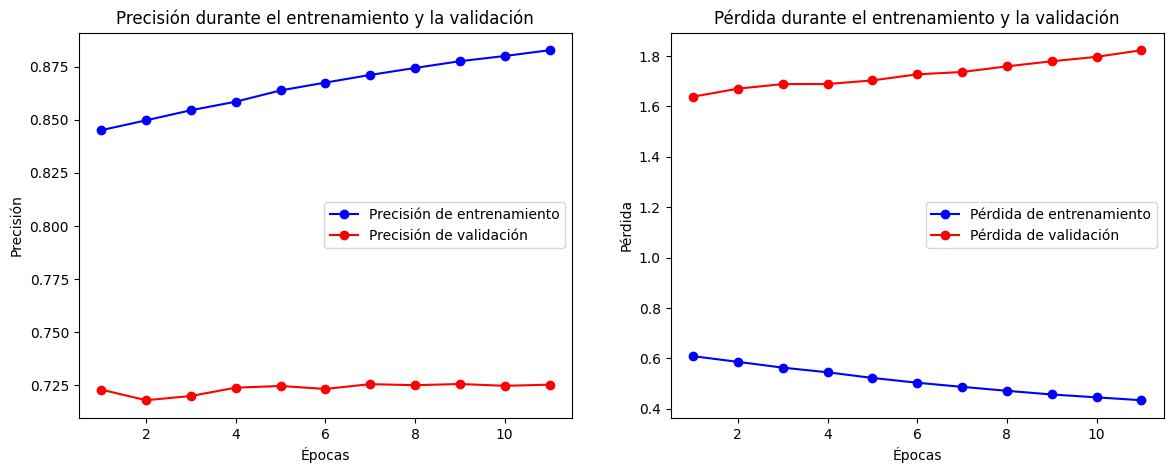

In [46]:
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Gráfico de precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Precisión de entrenamiento')
    plt.plot(epochs, val_acc, 'ro-', label='Precisión de validación')
    plt.title('Precisión durante el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Pérdida de entrenamiento')
    plt.plot(epochs, val_loss, 'ro-', label='Pérdida de validación')
    plt.title('Pérdida durante el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.show()

# Llamar a la función para graficar
plot_learning_curves(history)